In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import seaborn as sns
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
from keras.optimizers import Adam
%matplotlib inline
import cv2
import glob
from IPython.display import Image
import scipy as sp
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, concatenate, GlobalAveragePooling2D
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil
from PIL import Image

In [4]:
# get text data
image_path ="/content/drive/MyDrive/CSC180/Final Project/archive/filtered_images/"
data = pd.read_csv("/content/drive/MyDrive/CSC180/Final Project/archive/metadata/Train.csv")

In [5]:
data.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0


In [6]:
# Count the number of rows for each class
class_counts = data['class'].value_counts()

# Display the counts for each class
print(class_counts)

class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64


In [7]:
# Count the frequency of each Image_ID
image_id_counts = data['Image_ID'].value_counts()

# Display the top 10 Image_IDs and their counts
print("Top 10 most frequent Image IDs with their counts:")
image_id_counts.head(100)


Top 10 most frequent Image IDs with their counts:


,count
Image_ID,
id_mzq1jmom69.jpg,92
id_tmtzoe9bns.jpg,85
id_7tgo99b7gy.jpg,74
id_1xpbtfb4xh.jpg,74
id_n5talfnmmk.jpg,73
...,...
id_fa626uztwq.jpg,33
id_6bs4zqzvfr.jpg,33
id_wus57zro6l.jpg,33


In [8]:
unique_image_ids = data['Image_ID'].unique()
# Get the first 100 images
first_100_image_ids = unique_image_ids[:100]
print(len(first_100_image_ids))

100


In [9]:
print(unique_image_ids)

['id_u3q6jdck4j.jpg' 'id_a6cl90trri.jpg' 'id_qvc2le9sm8.jpg' ...
 'id_t00wtcn82l.jpg' 'id_8qftjzdycu.jpg' 'id_yx96nfd1zc.jpg']


In [10]:
# Get patches for each class
trophozoite_data = data[data['class'] == 'Trophozoite']
wbc_data = data[data['class'] == 'WBC']
neg_data = data[data['class'] == 'NEG']

In [11]:
print(trophozoite_data)
print(wbc_data)
print(neg_data)

                Image_ID        class  confidence  ymin  xmin  ymax  xmax
0      id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270
1      id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604
2      id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914
3      id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823
7      id_i8qcpi8ey9.jpg  Trophozoite         1.0   501  1141   532  1170
...                  ...          ...         ...   ...   ...   ...   ...
23522  id_8ken1mdqby.jpg  Trophozoite         1.0   370  2077   470  2188
23524  id_vdfvv10yri.jpg  Trophozoite         1.0   378  1001   404  1029
23527  id_ipmba1040m.jpg  Trophozoite         1.0   456   497   486   535
23528  id_r2x9t2l5cd.jpg  Trophozoite         1.0  2974  1039  3094  1165
23529  id_hw550kq3v2.jpg  Trophozoite         1.0   823   348   876   397

[15838 rows x 7 columns]
                Image_ID class  confidence  ymin  xmin  ymax  xmax
5      id_i7r9hkhxv

In [12]:
def load_images(image_path, image_ids):
    """
    Load all images once and store them in a dictionary for quick access.
    """
    image_cache = {}
    for idx, image_id in enumerate(image_ids):
        print(f"Processing image {idx + 1} of {len(image_ids)}")
        img = load_img(os.path.join(image_path, image_id))
        img = img_to_array(img) / 255.0  # Normalize image (values between 0 and 1)
        image_cache[image_id] = img

    return image_cache

In [13]:
# Get the top 10 Image_IDs from the Series
top_10_image_ids = image_id_counts.head(10).index

In [14]:
top_10_image_ids

Index(['id_mzq1jmom69.jpg', 'id_tmtzoe9bns.jpg', 'id_7tgo99b7gy.jpg',
       'id_1xpbtfb4xh.jpg', 'id_n5talfnmmk.jpg', 'id_bu04j7jxbr.jpg',
       'id_15rb0dgq66.jpg', 'id_wd51nh9072.jpg', 'id_ugc3d0uqrm.jpg',
       'id_i0sssks1lo.jpg'],
      dtype='object', name='Image_ID')

In [15]:
image_cache = load_images(image_path, image_id_counts.head(200).index)

Processing image 1 of 200
Processing image 2 of 200
Processing image 3 of 200
Processing image 4 of 200
Processing image 5 of 200
Processing image 6 of 200
Processing image 7 of 200
Processing image 8 of 200
Processing image 9 of 200
Processing image 10 of 200
Processing image 11 of 200
Processing image 12 of 200
Processing image 13 of 200
Processing image 14 of 200
Processing image 15 of 200
Processing image 16 of 200
Processing image 17 of 200
Processing image 18 of 200
Processing image 19 of 200
Processing image 20 of 200
Processing image 21 of 200
Processing image 22 of 200
Processing image 23 of 200
Processing image 24 of 200
Processing image 25 of 200
Processing image 26 of 200
Processing image 27 of 200
Processing image 28 of 200
Processing image 29 of 200
Processing image 30 of 200
Processing image 31 of 200
Processing image 32 of 200
Processing image 33 of 200
Processing image 34 of 200
Processing image 35 of 200
Processing image 36 of 200
Processing image 37 of 200
Processing

In [16]:
print(image_cache.keys())

dict_keys(['id_mzq1jmom69.jpg', 'id_tmtzoe9bns.jpg', 'id_7tgo99b7gy.jpg', 'id_1xpbtfb4xh.jpg', 'id_n5talfnmmk.jpg', 'id_bu04j7jxbr.jpg', 'id_15rb0dgq66.jpg', 'id_wd51nh9072.jpg', 'id_ugc3d0uqrm.jpg', 'id_i0sssks1lo.jpg', 'id_k061rd9uty.jpg', 'id_5bbz3srksa.jpg', 'id_d9km9wq3gf.jpg', 'id_tbop9cccoc.jpg', 'id_2phbgf1x5m.jpg', 'id_s91hx9uyin.jpg', 'id_ta824awk8u.jpg', 'id_nw02fw99a0.jpg', 'id_gzxlbrjcqz.jpg', 'id_r7rcvu1zc8.jpg', 'id_331urb6uko.jpg', 'id_sv9q2kedlr.jpg', 'id_yzhkb0zf37.jpg', 'id_xculy3gzpk.jpg', 'id_f1532fixpr.jpg', 'id_vttvw22xt6.jpg', 'id_ib4bkb6uto.jpg', 'id_1la6dmk7pp.jpg', 'id_5gudsszz0t.jpg', 'id_pms9qxpoz3.jpg', 'id_is6qvm3hoj.jpg', 'id_23rsmol80e.jpg', 'id_jewa1kipr1.jpg', 'id_zg9jc73sf7.jpg', 'id_ysi2242k6l.jpg', 'id_p1z8i43g1e.jpg', 'id_1gs2mk1ts7.jpg', 'id_n0dqkovtp3.jpg', 'id_69tmhfv0lu.jpg', 'id_uahbj2v0w9.jpg', 'id_43cevf8y4e.jpg', 'id_3r8qyxxxxc.jpg', 'id_jo8uyjrgbt.jpg', 'id_3t3uk40b2i.jpg', 'id_eb4ghgzugp.jpg', 'id_okva4xz4nj.jpg', 'id_r90wmxlo7g.jpg', 'i

In [17]:
# Iterate over the top 10 images and display them TESTING ONLY
# for idx, image_id in enumerate(image_cache.keys()):
#     plt.figure(figsize=(4, 4))
#     plt.imshow(image_cache[image_id])
#     plt.title(f"Image ID: {image_id}")
#     plt.axis('off')  # Hide axes
#     plt.show()
#     print(f"Displayed image {idx + 1} of 200 with ID: {image_id}")

In [18]:
print(neg_data)

                Image_ID class  confidence  ymin  xmin  ymax  xmax
4      id_6dop09rk02.jpg   NEG         1.0     0     0     0     0
8      id_y0me081u0v.jpg   NEG         1.0     0     0     0     0
63     id_2pye2ftpl6.jpg   NEG         1.0     0     0     0     0
72     id_4rut0xcvto.jpg   NEG         1.0     0     0     0     0
80     id_7c46h00wjj.jpg   NEG         1.0     0     0     0     0
...                  ...   ...         ...   ...   ...   ...   ...
23358  id_zzmhan693n.jpg   NEG         1.0     0     0     0     0
23403  id_q2xktm7v8n.jpg   NEG         1.0     0     0     0     0
23439  id_18vohhd1kx.jpg   NEG         1.0     0     0     0     0
23483  id_t00wtcn82l.jpg   NEG         1.0     0     0     0     0
23502  id_yx96nfd1zc.jpg   NEG         1.0     0     0     0     0

[688 rows x 7 columns]


In [19]:

def get_patches(image, box, patch_size):
    """
    Extract patches from the image based on the bounding box coordinates.
    """
    ymin, xmin, ymax, xmax = box
    patches = []

    # Validate bounding box
    if ymin >= ymax or xmin >= xmax:
        print(f"Invalid bounding box coordinates: {box}")
        return patches

    # Loop over the bounding box to extract patches
    for y in range(ymin, ymax, patch_size):
        for x in range(xmin, xmax, patch_size):
            patch = image[y:min(y + patch_size, ymax), x:min(x + patch_size, xmax)]

            # Resize the patch if it's smaller than target patch size
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                patch = cv2.resize(patch, (patch_size, patch_size))  # Upscale smaller patches

            patches.append(patch)

    if not patches:
        print(f"No patches generated for box: {box}")

    return patches

# get NEG patches seperately

def generate_neg_patches_random(image_path, neg_data, target_size=(128, 128), num_patches_per_image=3, buffer=500):
    """
    Generate random patches of size `target_size` from NEG images with a buffer to avoid corners.
    """
    neg_patches, neg_labels, neg_ids = [], [], []

    print("Starting to generate NEG patches...")

    # Iterate over each unique NEG image ID in neg_data
    for image_id in neg_data['Image_ID'].unique():
        # Construct the full path to the image
        image_file_path = os.path.join(image_path, image_id)

        # Load the image from the specified path
        image = cv2.imread(image_file_path)
        if image is None or image.size == 0:
            print(f"NEG Image {image_id} could not be loaded or is empty from path {image_file_path}.")
            continue

        # Get image dimensions
        height, width, _ = image.shape

        # Ensure the patch fits within the dimensions and add buffer
        if height <= target_size[0] + 2 * buffer or width <= target_size[1] + 2 * buffer:
            print(f"Image {image_id} is too small to apply buffer of {buffer}. Skipping this image.")
            continue

        # Generate a number of random patches per image
        for _ in range(num_patches_per_image):
            # Randomly select top-left corner for the patch within the buffered region
            y = random.randint(buffer, height - target_size[0] - buffer)
            x = random.randint(buffer, width - target_size[1] - buffer)

            # Extract the patch from the image
            patch = image[y:y + target_size[0], x:x + target_size[1]]
            neg_patches.append(patch)
            neg_labels.append("NEG")  # Use string label "NEG"
            neg_ids.append(image_id)
            print(f"Added NEG patch from {image_id} at ({y}, {x})")

    print(f"Generated {len(neg_patches)} NEG patches.")
    return np.array(neg_patches), np.array(neg_labels), neg_ids


In [20]:

def generate_patches_for_images(image_cache, data, target_size=(128, 128), patch_size=128):
    """
    Generate patches for WBC and Trophozoite images based on the bounding boxes in the dataset.
    """
    trophozoite_patches, trophozoite_labels, trophozoite_ids = [], [], []
    wbc_patches, wbc_labels, wbc_ids = [], [], []

    print("Starting to generate Trophozoite and WBC patches...")

    # Filter out NEG images from the dataset
    filtered_data = data[data['class'] != 'NEG']

    # Iterate through each unique image ID
    for image_id, image in image_cache.items():
        # Check if the image is valid
        if image is None or image.size == 0:
            print(f"Image {image_id} is empty or not loaded properly.")
            continue

        # Find the rows in the dataset that match the current image ID
        image_data = filtered_data[filtered_data['Image_ID'] == image_id]

        if image_data.empty:
            continue

        # For each matching row, get the bounding box and create patches
        for _, row in image_data.iterrows():
            label = row['class']
            box = [row['ymin'], row['xmin'], row['ymax'], row['xmax']]

            # Check if bounding box is valid
            ymin, xmin, ymax, xmax = box
            if ymin >= ymax or xmin >= xmax:
                print(f"Invalid bounding box coordinates: {box}")
                continue

            # Generate patches for Trophozoite and WBC
            image_patches = get_patches(image, box, patch_size)
            if not image_patches:
                print(f"No patches created for bounding box {box} in image {image_id}.")
                continue

            for patch in image_patches:
                patch_resized = cv2.resize(patch, target_size)
                if label == 'Trophozoite':
                    trophozoite_patches.append(patch_resized)
                    trophozoite_labels.append(label)
                    trophozoite_ids.append(image_id)
                    print(f"Added Trophozoite patch from {image_id}")
                elif label == 'WBC':
                    wbc_patches.append(patch_resized)
                    wbc_labels.append(label)
                    wbc_ids.append(image_id)
                    print(f"Added WBC patch from {image_id}")

    print(f"Generated {len(trophozoite_patches)} Trophozoite patches and {len(wbc_patches)} WBC patches.")
    return (np.array(trophozoite_patches), np.array(trophozoite_labels), trophozoite_ids,
            np.array(wbc_patches), np.array(wbc_labels), wbc_ids)


In [21]:
# Generate patches for NEG class

neg_patches, neg_labels, neg_ids = generate_neg_patches_random(image_path, neg_data)

Starting to generate NEG patches...
Added NEG patch from id_6dop09rk02.jpg at (1347, 731)
Added NEG patch from id_6dop09rk02.jpg at (566, 2314)
Added NEG patch from id_6dop09rk02.jpg at (1105, 2497)
Added NEG patch from id_y0me081u0v.jpg at (2360, 984)
Added NEG patch from id_y0me081u0v.jpg at (1252, 1631)
Added NEG patch from id_y0me081u0v.jpg at (2186, 947)
Added NEG patch from id_2pye2ftpl6.jpg at (1952, 2383)
Added NEG patch from id_2pye2ftpl6.jpg at (2162, 1253)
Added NEG patch from id_2pye2ftpl6.jpg at (825, 1474)
Added NEG patch from id_4rut0xcvto.jpg at (1029, 536)
Added NEG patch from id_4rut0xcvto.jpg at (1405, 3170)
Added NEG patch from id_4rut0xcvto.jpg at (862, 1596)
Added NEG patch from id_7c46h00wjj.jpg at (831, 2859)
Added NEG patch from id_7c46h00wjj.jpg at (1298, 3018)
Added NEG patch from id_7c46h00wjj.jpg at (1160, 1027)
Added NEG patch from id_o6g0y0lypq.jpg at (1280, 2058)
Added NEG patch from id_o6g0y0lypq.jpg at (1042, 3042)
Added NEG patch from id_o6g0y0lypq.jp

In [22]:
(trophozoite_patches, trophozoite_labels, trophozoite_ids,
 wbc_patches, wbc_labels, wbc_ids) = generate_patches_for_images(image_cache, data)

Streaming output truncated to the last 5000 lines.
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Trophozoite patch from id_bw8mq2lrsq.jpg
Added Tro

In [23]:

# Check the shape of the final image array
print("Troph data", trophozoite_patches.shape) # , trophozoite_labels, trophozoite_ids
print("WBC data", wbc_patches.shape) # ,  wbc_labels
print("NEG data", neg_patches.shape) # , neg_labels, neg_ids
#print(greyImages_array.shape)

Troph data (5933, 128, 128, 3)
WBC data (2189, 128, 128, 3)
NEG data (2064, 128, 128, 3)


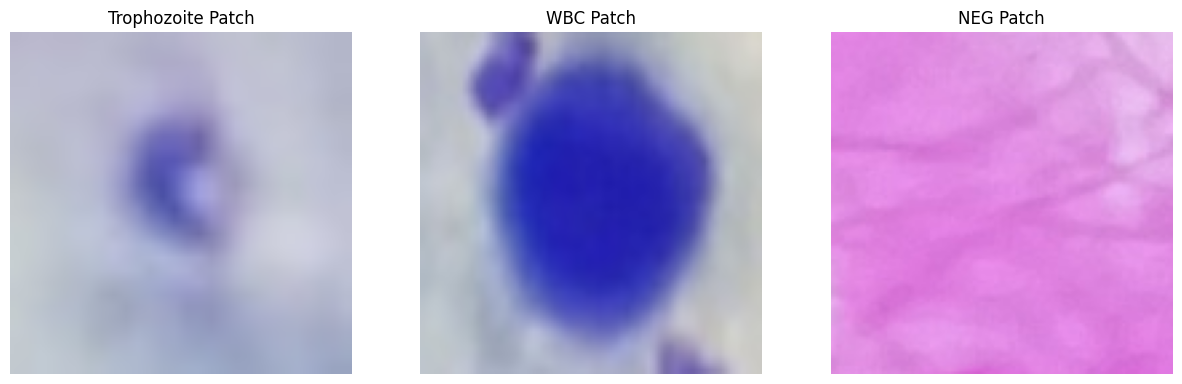

In [39]:
# Display one of each image
# Display one sample patch from each actual dataset of patches (trophozoite, WBC, NEG)

# Function to display a single patch from each class
def display_real_sample_patches(trophozoite_patches, wbc_patches, neg_patches):
    plt.figure(figsize=(15, 5))

    # Display Trophozoite patch
    plt.subplot(1, 3, 1)
    plt.imshow(trophozoite_patches[0])
    plt.title("Trophozoite Patch")
    plt.axis('off')

    # Display WBC patch
    plt.subplot(1, 3, 2)
    plt.imshow(wbc_patches[0])
    plt.title("WBC Patch")
    plt.axis('off')

    # Display NEG patch
    plt.subplot(1, 3, 3)
    plt.imshow(neg_patches[0])
    plt.title("NEG Patch")
    plt.axis('off')

    plt.show()

# Call the function to display real patches
display_real_sample_patches(trophozoite_patches, wbc_patches, neg_patches)


In [25]:
# Combine the patches into one dataset
all_patches = np.concatenate([trophozoite_patches, wbc_patches, neg_patches]) # , neg_patches
all_labels = np.concatenate([trophozoite_labels, wbc_labels, neg_labels]) # , neg_labels

In [26]:
def load_and_preprocess_image(image_id):
    image_file = os.path.join(image_path, image_id)
    img = load_img(image_file, target_size=(128, 128))  # Resize image as needed
    img = img_to_array(img) / 255.0  # Normalize image (values between 0 and 1)

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert RGB image to grayscale
    gray_img = np.expand_dims(gray_img, axis=-1)  # Add a channel dimension to make it (128, 128, 1)

    return img, gray_img  # Return both RGB and grayscale images

In [27]:
label_mapping = {'Trophozoite': 0, 'WBC': 1, 'NEG': 2} # , 'NEG': 2

# Convert string labels to integer labels
labels = np.concatenate([trophozoite_labels, wbc_labels, neg_labels]) # , neg_labels
numeric_labels = np.array([label_mapping[label] for label in labels])
one_hot_labels = to_categorical(numeric_labels, num_classes=3)


In [28]:
print(len(one_hot_labels))
print(len(all_patches))

10186
10186


# CNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         401,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 516,323 (1.97 MB)

 Trainable params: 516,323 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

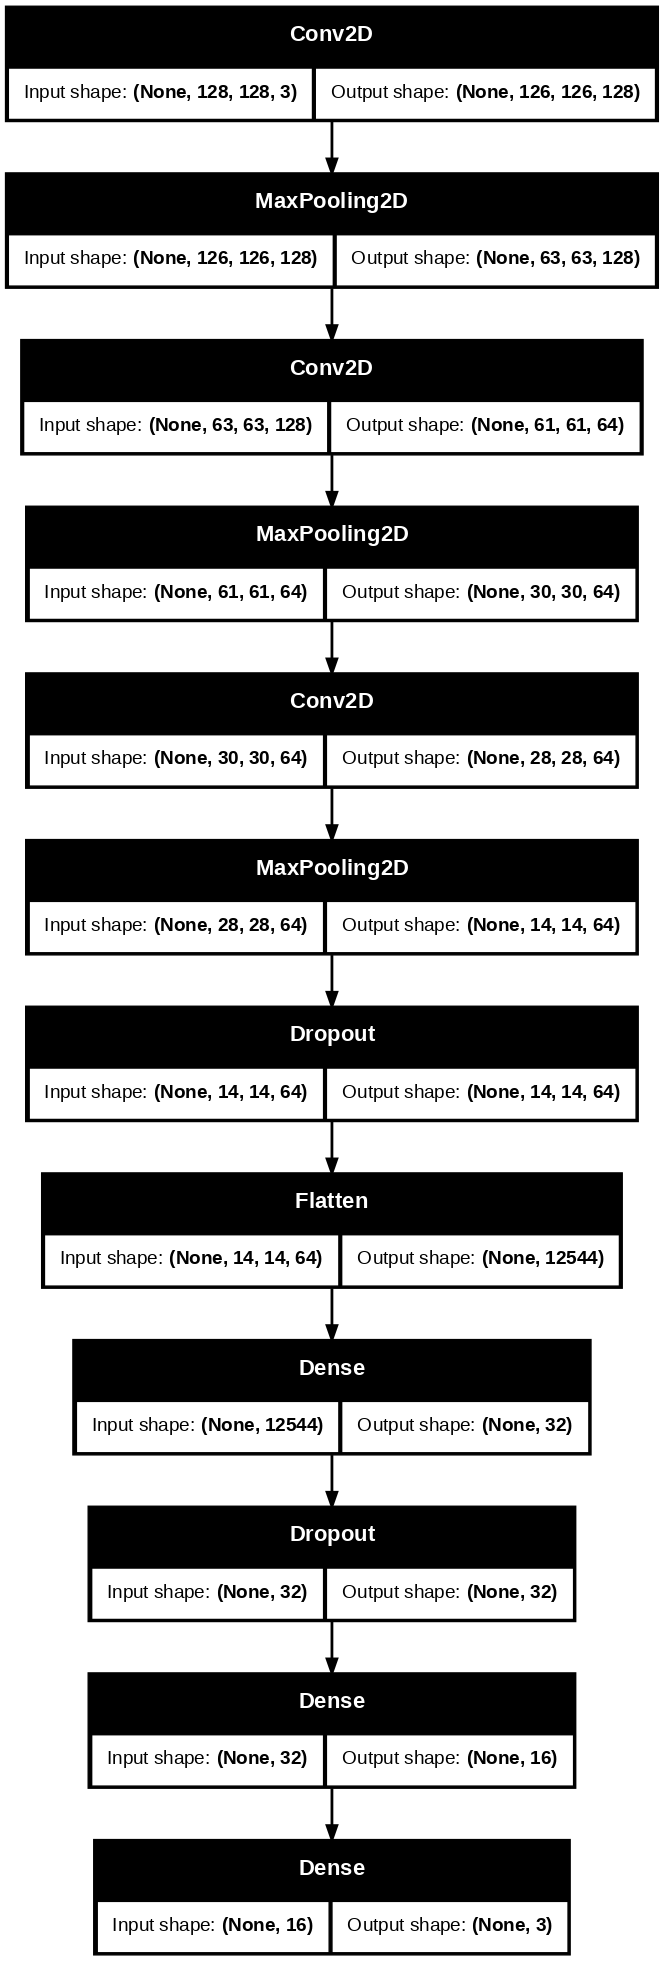

In [29]:
# Define CNN model
cnn_model = Sequential()

# Add convolutional layers
cnn_model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # Input is 128x128 image
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))  # 2nd Conv layer
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))  # 3rd Conv layer
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.5))
# cnn_model.add(Dropout(0.5))
# Flatten feature maps for Dense layers
cnn_model.add(Flatten())

# Fully connected dense layers
cnn_model.add(Dense(32, activation='relu'))  # 1st dense layer
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(16, activation='relu'))  # 2nd dense layer

# Output layer
cnn_model.add(Dense(3, activation='softmax'))

# Adam optimizer with a reduced learning rate
adam_optimizer = Adam(learning_rate=0.001)
# Compiling
cnn_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


cnn_model.summary()
plot_model(cnn_model, show_shapes=True, dpi=100)

In [30]:
# Combine all patches
all_patches = np.concatenate([trophozoite_patches, wbc_patches, neg_patches]) # , neg_patches

# Split data into training and validation sets (using 80% for training and 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(all_patches, one_hot_labels, test_size=0.2, random_state=42)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5) # , restore_best_weights=True

# Train the model with early stopping
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

y_true = np.argmax(y_val, axis=1)

# Get predictions from the model
y_pred_probs = cnn_model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Get class predictions

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred_classes)

# Print accuracy score
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.5777 - loss: 1.0768 - val_accuracy: 0.9789 - val_loss: 0.0928
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9394 - loss: 0.1781 - val_accuracy: 0.9809 - val_loss: 0.0720
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9525 - loss: 0.1455 - val_accuracy: 0.9745 - val_loss: 0.1001
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9538 - loss: 0.1386 - val_accuracy: 0.9814 - val_loss: 0.0787
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9549 - loss: 0.1155 - val_accuracy: 0.9828 - val_loss: 0.0604
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9582 - loss: 0.1032 - val_accuracy: 0.9838 - val_loss: 0.0474
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9560 - loss: 0.1066 - val_accuracy: 0.9809 - val_loss: 0.0943
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9626 - loss: 0.1027 - val_acc

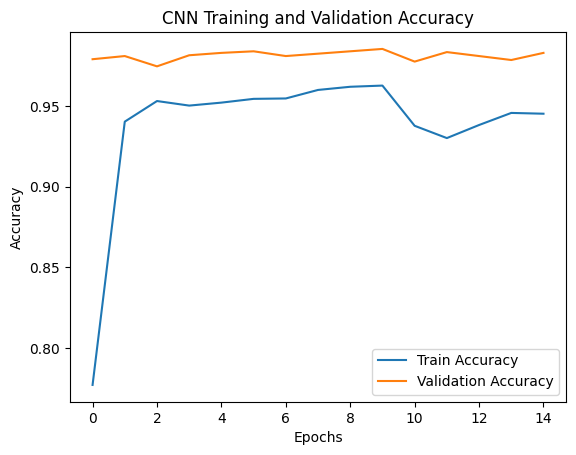

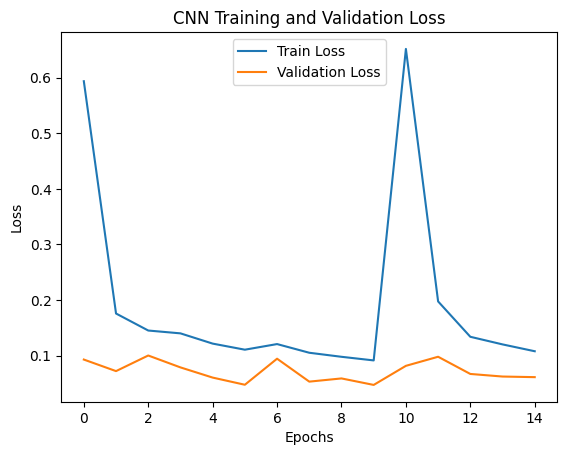

In [31]:
# Jaskirt Kaler
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')  # CNN training accuracy
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')  # CNN validation accuracy
plt.legend()
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training and validation loss for CNN
plt.plot(cnn_history.history['loss'], label='Train Loss')  # CNN training loss
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')  # CNN validation loss
plt.legend()
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [35]:
# Plot ROC curve for the model's predictions
def plot_roc_curve(pred, y_true):
    fpr, tpr, _ = roc_curve(y_true, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


Plotting ROC curve for class 0...


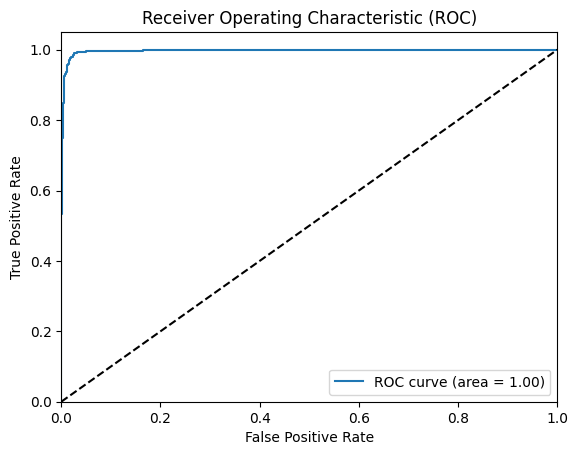

Plotting ROC curve for class 1...


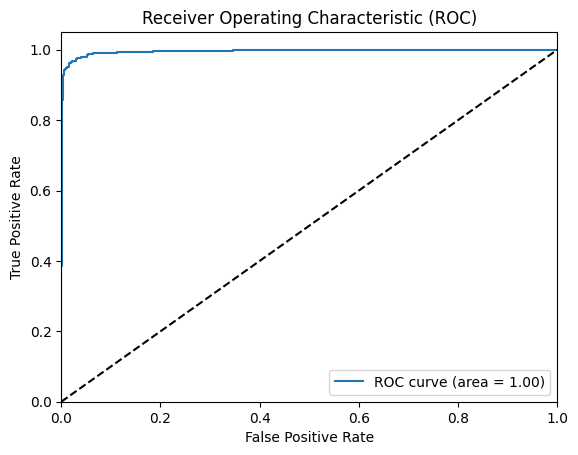

Plotting ROC curve for class 2...


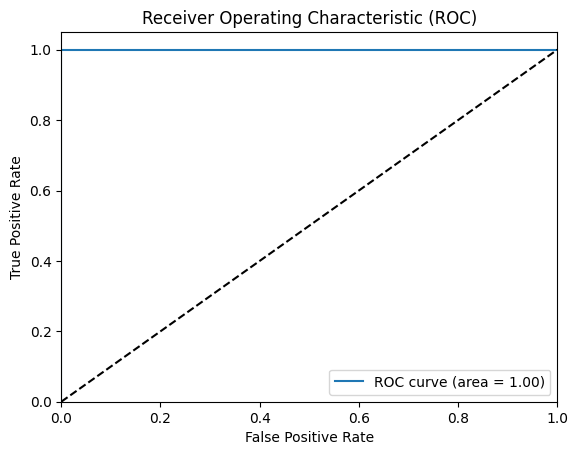

In [36]:
for i in range(3):  # Assuming 3 classes: Trophozoite, WBC, NEG
    print(f"Plotting ROC curve for class {i}...")
    plot_roc_curve(y_pred_probs[:, i], (y_true == i).astype(int))

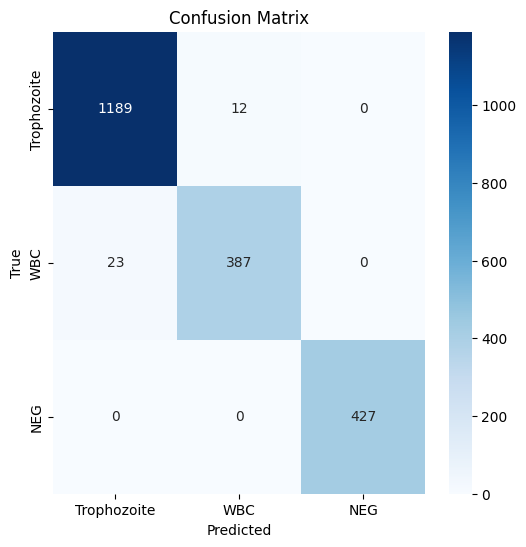

              precision    recall  f1-score   support

 Trophozoite       0.98      0.99      0.99      1201
         WBC       0.97      0.94      0.96       410
         NEG       1.00      1.00      1.00       427

    accuracy                           0.98      2038
   macro avg       0.98      0.98      0.98      2038
weighted avg       0.98      0.98      0.98      2038



In [38]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with class labels
labels = ['Trophozoite', 'WBC', 'NEG']  # Multi-class labels , 'NEG'
plt.figure(figsize=(6,6))  # Adjust figure size for better clarity
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))